In [1]:
import numpy as np
import os

from os.path import join
import matplotlib.pyplot as plt
from mayavi import mlab

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


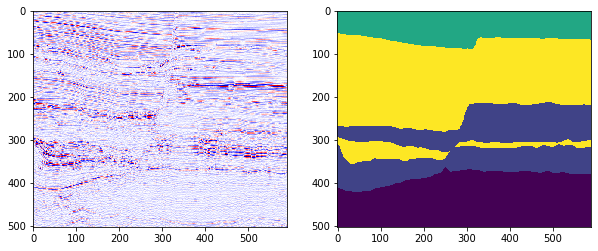

Mean: 0.6758
Standard Deviation: 390.3154
Maximum: 5088.9844
Minimum: -5195.5234
Unique Labels: [1. 2. 3. 4. 5. 6.]


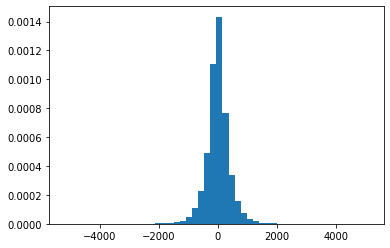

In [2]:
# Obtain paths for training data and labels
working_directory = os.getcwd()  # Get working directory
training_data_path= join(working_directory,'data', 'training_data.npy')
training_label_path = join(working_directory,'data','training_labels.npy')

# load the data
seismic = np.load(training_data_path)[:,:,::2] # downsample depth by 2 
labels = np.load(training_label_path)[:,:,::2] # same shape as seismic cube

# Visualize the section and labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(seismic[:,0,:].T, cmap='seismic')
ax2.imshow(labels[:,0,:].T, vmin=1, vmax=6)
plt.show()

# Print data metrics
print('Mean: {:0.4f}'.format(seismic.mean()))
print('Standard Deviation: {:0.4f}'.format(seismic.std()))
print('Maximum: {:0.4f}'.format(seismic.max()))
print('Minimum: {:0.4f}'.format(seismic.min()))
print('Unique Labels: {}'.format(np.unique(labels)))

# Plot histogram of seismic amplitude values
plt.hist(seismic.flatten(), bins=50, density=True)
plt.show()



Mean: 0.5000
Standard Deviation: 0.2159
Maximum: 1.0000
Minimum: 0.0000


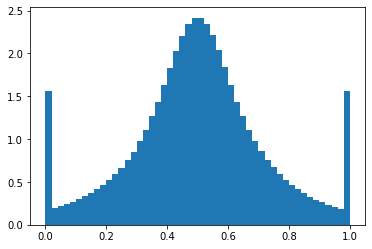

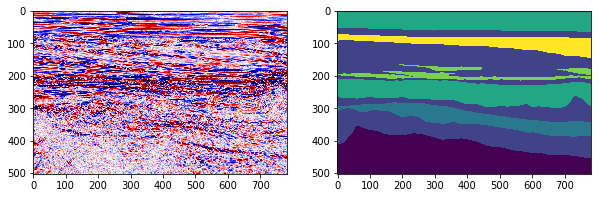

In [3]:
from utils import seismic_normalize

# Clip amplitudes to within a few standard deviations and normalize between 0 and 1
seismic = seismic_normalize(seismic, 2)

# bring labels into desired range for NLLL loss 
labels = labels - 1


# Print statistics for standardized data
print('Mean: {:0.4f}'.format(seismic.mean()))
print('Standard Deviation: {:0.4f}'.format(seismic.std()))
print('Maximum: {:0.4f}'.format(seismic.max()))
print('Minimum: {:0.4f}'.format(seismic.min()))
plt.hist(seismic.flatten(), bins=50, density=True)
plt.show()

# Visualize the normalized section and labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(seismic[0].T, cmap='seismic')
ax2.imshow(labels[0].T)
plt.show()

In [ ]:
from utils import create_3d_visualization

alpha = 0.5
scalars = alpha*labels/labels.max() + (1-alpha)*seismic
create_3d_visualization(scalars, (3, 3, 3))

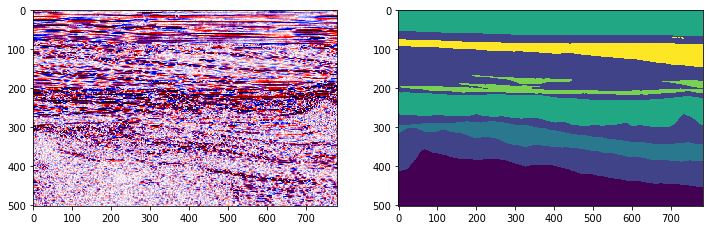

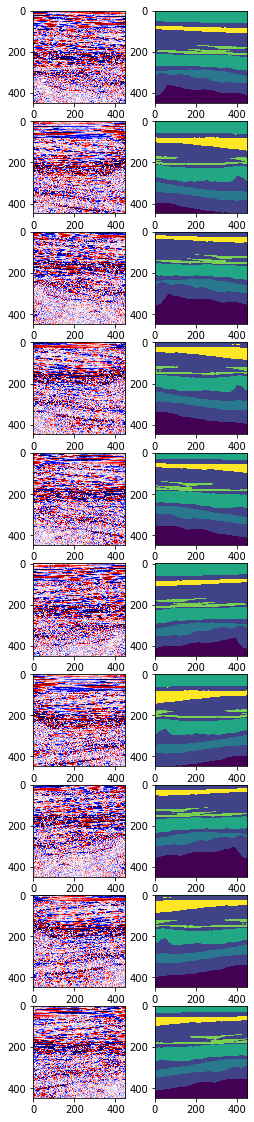

In [4]:
from utils import image_crop

section_num = 5
section = seismic[section_num].T  # Obtain seismic
label = labels[section_num].T  # Obtain corresponding label

# Obtain augmented images and labels. Crop size for parihaka dataset was 400
aug_images = image_crop(section, 448, 448)
aug_labels = image_crop(label, 448, 448)

# display original section
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,12))
ax1.imshow(section, cmap='seismic')
ax2.imshow(label)
plt.show()

# Display all 10 original + augmented crops
fig, ax = plt.subplots(10, 2, figsize=(4, 20))
for crop_number in range(10):
    ax[crop_number,0].imshow(aug_images[crop_number], cmap='seismic')
    ax[crop_number,1].imshow(aug_labels[crop_number])    
plt.show()    



In [5]:
from dataset import SeismicPatch
from torch.utils.data import Dataset, DataLoader

num_sections = 80  # num of sections in both crossline and xline orientations to train
patch_size = 448

# Train on crosslines
train_dataset_xline = SeismicPatch(seismic[100::6], labels[100::6], 'xline', patch_size, num_sections=num_sections)
train_loader_xline = DataLoader(train_dataset_xline, batch_size=1)

# Train on inlines
train_dataset_inline = SeismicPatch(seismic[:,100::8,:], labels[:,100::8,:], 'inline', patch_size, num_sections=num_sections)
train_loader_inline = DataLoader(train_dataset_inline, batch_size=1)

# Test on inlines
val_dataset = SeismicPatch(seismic[:, 3:5, :], labels[:, 3:5, :], 'inline', patch_size, num_sections=1)
val_loader = DataLoader(val_dataset, batch_size=1)


In [ ]:
data = labels
label_value = 5
mask = data==label_value
label_fraction = mask.sum() / (labels.shape[0]*labels.shape[1]*labels.shape[2])
label_weight = 1 / label_fraction
print(label_fraction, label_weight)

In [6]:
from models import UNet

writer = SummaryWriter(join(working_directory,'runs', 'exp_24_Parihaka_even_dataset_division_80samples_reweightedloss_14layer_Unet'))

# Initialize model and send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=6).to(device)

# Define weights for different classes
weight=torch.tensor([6, 2.4, 24, 3.5, 30, 11], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weight) # Set up criterion

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 20
batch_size = 1
total_batches = np.ceil(10/batch_size).astype(int)

prev_loss = torch.tensor(10000, dtype=torch.float, requires_grad=False)  # initial validation loss benchmark
for epoch in range(num_epochs):
    # start training
    for iteration, ((imgs_xline, lbls_xline), (imgs_inline, lbls_inline)) in enumerate(zip(train_loader_xline, train_loader_inline)):
        imgs_xline.transpose_(0,1)
        lbls_xline = lbls_xline.squeeze()
        imgs_inline.transpose_(0,1)
        lbls_inline = lbls_inline.squeeze()
        start_i = 0  # index of starting training samples
        for batch_number in range(total_batches):    
            model.train()
            optimizer.zero_grad()
            
            out_xline = model(imgs_xline[start_i:start_i+batch_size])
            out_inline = model(imgs_inline[start_i:start_i+batch_size])

            loss_train_xline = criterion(out_xline, lbls_xline[start_i:start_i+batch_size]) / total_batches            
            loss_train_inline = criterion(out_inline, lbls_inline[start_i:start_i+batch_size])/ total_batches
    
            loss_train_xline.backward()
            loss_train_inline.backward()
            
            optimizer.step()
            start_i += batch_size
            
        if iteration % 15 == 0:
                # Test on validation
                with torch.no_grad():
                    model.eval()
                    for imgs, lbls in val_loader:
                          out = model(imgs.transpose_(0, 1)[:5])
                          val_loss = criterion(out, lbls.squeeze()[:5])
                          fig, (ax1, ax2) = plt.subplots(1, 2)
                          ax1.imshow(out.argmax(dim=1)[0].detach().cpu().numpy(), vmin=labels.min(), vmax=labels.max())
                          ax2.imshow(lbls.squeeze()[0].detach().cpu().numpy(), vmin=labels.min(), vmax=labels.max())
                          writer.add_figure('Val_patch_0', fig, global_step=epoch*num_sections+iteration, close=True)
                          if val_loss.item() < prev_loss:
                              torch.save(model.state_dict(), join(working_directory,'best_val_model.pth'))
                              prev_loss = val_loss.item()
        
        writer.add_scalar('Loss/train', loss_train_inline.item()+loss_train_xline.item(), epoch*num_sections+iteration)                
        writer.add_scalar('Loss/val', val_loss.item(), epoch*num_sections+iteration)    
        print('Epoch: {} | Iteration: {} | Train Loss: {:0.4f} | Val Loss: {:0.4f}'.format(epoch,
                                                                                           iteration,
                                                                                           loss_train_inline.item()+
                                                                                           loss_train_xline.item(),
                                                                                           val_loss.item()))
            
    


Epoch: 0 | Iteration: 0 | Train Loss: 0.3551 | Val Loss: 1.7776
Epoch: 0 | Iteration: 1 | Train Loss: 0.3461 | Val Loss: 1.7776
Epoch: 0 | Iteration: 2 | Train Loss: 0.3397 | Val Loss: 1.7776
Epoch: 0 | Iteration: 3 | Train Loss: 0.3367 | Val Loss: 1.7776
Epoch: 0 | Iteration: 4 | Train Loss: 0.3326 | Val Loss: 1.7776
Epoch: 0 | Iteration: 5 | Train Loss: 0.3276 | Val Loss: 1.7776
Epoch: 0 | Iteration: 6 | Train Loss: 0.3214 | Val Loss: 1.7776
Epoch: 0 | Iteration: 7 | Train Loss: 0.3126 | Val Loss: 1.7776
Epoch: 0 | Iteration: 8 | Train Loss: 0.3016 | Val Loss: 1.7776
Epoch: 0 | Iteration: 9 | Train Loss: 0.2970 | Val Loss: 1.7776
Epoch: 0 | Iteration: 10 | Train Loss: 0.2964 | Val Loss: 1.7776
Epoch: 0 | Iteration: 11 | Train Loss: 0.2920 | Val Loss: 1.7776
Epoch: 0 | Iteration: 12 | Train Loss: 0.2899 | Val Loss: 1.7776
Epoch: 0 | Iteration: 13 | Train Loss: 0.2832 | Val Loss: 1.7776
Epoch: 0 | Iteration: 14 | Train Loss: 0.2718 | Val Loss: 1.7776
Epoch: 0 | Iteration: 15 | Train Lo

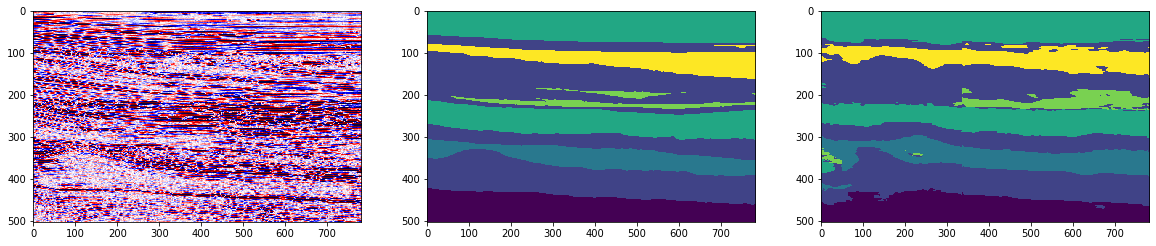

In [10]:
from utils import section_predict
 
 # load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=6).to(device)
model.load_state_dict(torch.load(join(working_directory, 'best_val_model.pth'))) 
 
# get the predictions 
section_num = 50
test_section = torch.from_numpy(seismic[section_num].T).cuda().float()
predicted_section = section_predict(model, test_section, patch_size)
label_section = labels[section_num].T


# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.imshow(test_section.detach().cpu(), cmap='seismic')
ax1.set_title('Seismic')
ax2.imshow(label_section, vmin=0, vmax=5)
ax2.set_title('Ground-Truth')
ax3.imshow(predicted_section.detach().cpu(), vmin=0, vmax=5)
ax3.set_title('Predicted')
plt.show()

In [11]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from utils import compute_labels

pred_label_volume_iline = compute_labels(seismic, model, patch_size=patch_size, orientation='crossline')      
pred_label_volume_xline = compute_labels(seismic, model, patch_size=patch_size, orientation='inline')

# print statistics for test 1
IOU = jaccard_score(labels[:100].flatten(), pred_label_volume_iline[:100].flatten(), labels=list(range(6)), average=None)
mPA = accuracy_score(labels[:100].flatten(), pred_label_volume_iline[:100].flatten())
print("IOU per class: ", IOU)
print("Test1 mIOU: {:0.4f}".format(IOU.mean()))
print("Test1 mPA: {:0.4f}".format(mPA))

# print statistics for test 2
IOU = jaccard_score(labels[:,1:100,:].flatten(), pred_label_volume_xline[:,1:100,:].flatten(), labels=list(range(6)), average=None)
mPA = accuracy_score(labels[:,1:100,:].flatten(), pred_label_volume_xline[:,1:100,:].flatten())
print("IOU per class: ", IOU)
print("Test2 mIOU: {:0.4f}".format(IOU.mean()))
print("Test2 mPA: {:0.4f}".format(mPA))


IOU per class:  [0.94175923 0.74097849 0.74336051 0.83806235 0.29876082 0.73706374]
Test1 mIOU: 0.7167
Test1 mPA: 0.8714
IOU per class:  [0.97377892 0.83510738 0.64861945 0.89427336 0.09873172 0.55047536]
Test2 mIOU: 0.6668
Test2 mPA: 0.9198


In [14]:
from utils import create_3d_visualization

alpha=0.5
scalars = alpha*pred_label_volume_iline + (1-alpha)*seismic 
create_3d_visualization(scalars, (0,0,0))

In [15]:
working_directory = os.getcwd()
test1_path = join(working_directory, 'data', 'TestData_Image1.npy')
test2_path = join(working_directory, 'data', 'TestData_Image2.npy')

test_seismic1 = np.load(test1_path)[:, :, ::2]
test_seismic2 = np.load(test2_path)[:, :, ::2]

#Preprocessing and data normalization
x1 = seismic_normalize(test_seismic1, 2)
x2 = seismic_normalize(test_seismic2, 2)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=6).to(device)
model.load_state_dict(torch.load(join(working_directory, 'best_val_model.pth'))) 

test1_labels = compute_labels(x1, model, 448, orientation='crossline')
test2_labels = compute_labels(x2, model, 448, orientation='inline')

In [19]:
alpha = 0.5
scalars = alpha*test1_labels + (1-alpha)*x1
create_3d_visualization(scalars, (0,0,0))

scalars = alpha*test2_labels + (1-alpha)*x2
create_3d_visualization(scalars, (0,0,0))


